# Definitions

In [127]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import ttest_ind, levene, chisquare, ttest_rel, mannwhitneyu
import numpy as np
import pingouin as pg
from statsmodels.stats.power import TTestIndPower
from brokenaxes import brokenaxes

In [128]:
no_students = [
    -10,-1,0,1, #system
    2, #admin
    67, 68, 70, 71, 87 #test accounts
]
select_courses = [2] 
subfolder =  "publish\\"
experimentalgroupid = 1
controlgroupid = 2
pretestid = 1
posttestid = 2
questionnaire_ageid = 4
questionnaire_genderid = 5
questionnaire_educationid = 6
experimentalgrouplongpageid = 2
controlgrouplongpageid = 11
pretestcontextid = 41
posttestcontextid = 55

# Power Analysis

In [129]:
obj = TTestIndPower()
n = obj.solve_power(effect_size=0.8, alpha=0.05, power=0.8, ratio=1, alternative='two-sided')
n*2

51.04914500095871

# Load group members

In [130]:
df_groupmembers = pd.read_csv(subfolder + "mdl_groups_members.csv", sep=";")
df_groupmembers

,id,groupid,userid,timeadded,component,itemid
0,105,1,72,1665059018,NaN,0
1,106,2,73,1665138586,NaN,0
2,107,1,74,1665142078,NaN,0
3,108,2,75,1665148871,NaN,0
4,109,2,76,1665153132,NaN,0
...,...,...,...,...,...,...
391,507,2,474,1666868092,NaN,0
392,508,2,475,1666876673,NaN,0
393,509,2,476,1666877057,NaN,0
394,510,2,477,1666898416,NaN,0


# Preprocessing logs

In [131]:
df_log = pd.read_csv(subfolder + "mdl_logstore_standard_log.csv", sep=";")
#convert unix timestamp
df_log.loc[:,"timecreated"] = pd.to_datetime(df_log.loc[:,"timecreated"], unit = "s")
df_log

,Unnamed: 0,id,eventname,component,action,target,objecttable,objectid,crud,edulevel,...,contextlevel,contextinstanceid,userid,courseid,relateduserid,anonymous,other,timecreated,origin,realuserid
0,0,1,\core\event\user_loggedin,core,loggedin,user,user,2.0,r,0,...,10,0,2,0,NaN,0,"a:1:{s:8:""username"";s:5:""admin"";}",2022-06-30 10:10:26,web,NaN
1,1,2,\core\event\user_password_updated,core,updated,user_password,NaN,NaN,u,0,...,30,2,2,0,2.0,0,"a:1:{s:14:""forgottenreset"";b:0;}",2022-06-30 10:11:39,web,NaN
2,2,3,\core\event\user_updated,core,updated,user,user,2.0,u,0,...,30,2,2,0,2.0,0,N;,2022-06-30 10:11:39,web,NaN
3,3,4,\core\event\config_log_created,core,created,config_log,config_log,712.0,c,0,...,10,0,2,0,NaN,0,"a:4:{s:4:""name"";s:24:""enableaccessibilitytools...",2022-06-30 10:11:44,web,NaN
4,4,5,\core\event\config_log_created,core,created,config_log,config_log,713.0,c,0,...,10,0,2,0,NaN,0,"a:4:{s:4:""name"";s:17:""notloggedinroleid"";s:8:""...",2022-06-30 10:11:44,web,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67653,67653,67654,\tool_langimport\event\langpack_updated,tool_langimport,updated,langpack,NaN,NaN,u,0,...,10,0,2,0,NaN,0,"{""langcode"":""de""}",2022-10-28 02:50:02,cli,NaN
67654,67654,67655,\core\event\user_loggedin,core,loggedin,user,user,2.0,r,0,...,10,0,2,0,NaN,0,"{""username"":""admin""}",2022-10-28 07:04:46,web,NaN
67655,67655,67656,\core\event\question_viewed,core,viewed,question,question,1.0,r,1,...,70,7,2,2,NaN,0,"{""categoryid"":""2""}",2022-10-28 07:04:47,web,NaN
67656,67656,67657,\mod_quiz\event\report_viewed,mod_quiz,viewed,report,NaN,NaN,r,1,...,70,6,2,2,NaN,0,"{""quizid"":""1"",""reportname"":""statistics""}",2022-10-28 07:55:20,web,NaN


In [132]:
#only scroll actions
df_scroll = df_log[df_log["action"] == "scroll"]
df_scroll

,Unnamed: 0,id,eventname,component,action,target,objecttable,objectid,crud,edulevel,...,contextlevel,contextinstanceid,userid,courseid,relateduserid,anonymous,other,timecreated,origin,realuserid
20995,20995,20996,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,70,86,2,2,NaN,0,"{""longpageid"":1,""relativeTime"":5394.14,""target...",2022-10-04 08:45:26,web,NaN
21008,21008,21009,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,70,86,2,2,NaN,0,"{""longpageid"":1,""relativeTime"":5394.14,""target...",2022-10-04 08:45:26,web,NaN
21017,21017,21018,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,70,86,2,2,NaN,0,"{""longpageid"":1,""relativeTime"":7877.48,""target...",2022-10-04 08:45:28,web,NaN
21018,21018,21019,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,70,86,2,2,NaN,0,"{""longpageid"":1,""relativeTime"":7877.48,""target...",2022-10-04 08:45:28,web,NaN
21019,21019,21020,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,70,86,2,2,NaN,0,"{""longpageid"":1,""relativeTime"":8827.48,""target...",2022-10-04 08:45:29,web,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67594,67594,67595,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,70,86,474,2,NaN,0,"{""longpageid"":2,""relativeTime"":38686,""targetID...",2022-10-27 10:56:52,web,NaN
67595,67595,67596,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,70,86,474,2,NaN,0,"{""longpageid"":2,""relativeTime"":38683,""targetID...",2022-10-27 10:56:52,web,NaN
67598,67598,67599,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,70,86,474,2,NaN,0,"{""longpageid"":2,""relativeTime"":38802,""targetID...",2022-10-27 10:56:52,web,NaN
67599,67599,67600,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,70,86,474,2,NaN,0,"{""longpageid"":2,""relativeTime"":38802,""targetID...",2022-10-27 10:56:52,web,NaN


## Filter courses

<AxesSubplot:>

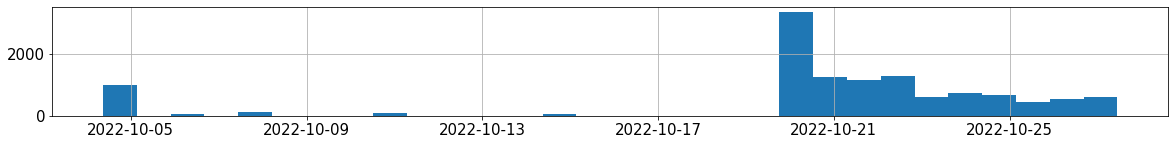

In [133]:
df_scroll = df_scroll[(df_scroll.courseid.isin(select_courses))]
df_scroll.timecreated.sort_values().hist(bins=df_scroll.timecreated.dt.date.nunique()*2)

## Join "other" columns

In [134]:
#extract json to columns
other = pd.json_normalize(df_scroll.other.apply(json.loads)).set_index(df_scroll.index)
other

,longpageid,relativeTime,targetID,targetTag,targetClasses,targetWordCount,targetHeight,scrollLeft,scrollTop,scrollHeight,scrollWidth,containerHeight,containerWidth,behavior,sectionhash,sectionCount
20995,1,5394.14,paragraph-1,p,longpage-paragraph,51,162,0.0,99.0,148,-17,0,0,scrolling,660810642,60
21008,1,5394.14,paragraph-2,h3,longpage-paragraph,7,33,0.0,99.0,148,-17,0,0,scrolling,660810643,60
21017,1,7877.48,paragraph-4,h4,longpage-paragraph,5,28,0.0,99.0,148,-17,0,0,scrolling,660810645,60
21018,1,7877.48,paragraph-3,p,longpage-paragraph,98,270,0.0,99.0,148,-17,0,0,scrolling,660810644,60
21019,1,8827.48,paragraph-0,p,longpage-paragraph,4,72,0.0,8.0,148,-17,0,0,scrolling,660810641,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67594,2,38686.00,paragraph-52,h4,longpage-paragraph,5,27,0.0,9494.0,0,0,0,0,scrolling,-989706404,60
67595,2,38683.00,paragraph-53,p,longpage-paragraph,65,135,0.0,9584.0,0,0,0,0,scrolling,-989706403,60
67598,2,38802.00,paragraph-50,p,longpage-paragraph,242,486,0.0,8988.0,0,0,0,0,scrolling,-989706406,60
67599,2,38802.00,paragraph-49,h4,longpage-paragraph,5,27,0.0,8988.0,0,0,0,0,scrolling,-989706428,60


In [135]:
#join columns from json
df_scroll = df_scroll.join(other, rsuffix="_other")
df_scroll["paragraph"] = df_scroll["targetID"].str.replace("paragraph-", "").astype(int) + 1
df_scroll

,Unnamed: 0,id,eventname,component,action,target,objecttable,objectid,crud,edulevel,...,scrollLeft,scrollTop,scrollHeight,scrollWidth,containerHeight,containerWidth,behavior,sectionhash,sectionCount,paragraph
20995,20995,20996,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,0.0,99.0,148,-17,0,0,scrolling,660810642,60,2
21008,21008,21009,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,0.0,99.0,148,-17,0,0,scrolling,660810643,60,3
21017,21017,21018,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,0.0,99.0,148,-17,0,0,scrolling,660810645,60,5
21018,21018,21019,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,0.0,99.0,148,-17,0,0,scrolling,660810644,60,4
21019,21019,21020,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,0.0,8.0,148,-17,0,0,scrolling,660810641,60,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67594,67594,67595,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,0.0,9494.0,0,0,0,0,scrolling,-989706404,60,53
67595,67595,67596,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,0.0,9584.0,0,0,0,0,scrolling,-989706403,60,54
67598,67598,67599,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,0.0,8988.0,0,0,0,0,scrolling,-989706406,60,51
67599,67599,67600,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,0.0,8988.0,0,0,0,0,scrolling,-989706428,60,50


## Join groups to users in logs

In [136]:
df_scroll = df_scroll.merge(df_groupmembers[["groupid", "userid"]], on="userid", how="left")
df_scroll

,Unnamed: 0,id,eventname,component,action,target,objecttable,objectid,crud,edulevel,...,scrollTop,scrollHeight,scrollWidth,containerHeight,containerWidth,behavior,sectionhash,sectionCount,paragraph,groupid
0,20995,20996,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,99.0,148,-17,0,0,scrolling,660810642,60,2,NaN
1,21008,21009,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,99.0,148,-17,0,0,scrolling,660810643,60,3,NaN
2,21017,21018,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,99.0,148,-17,0,0,scrolling,660810645,60,5,NaN
3,21018,21019,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,99.0,148,-17,0,0,scrolling,660810644,60,4,NaN
4,21019,21020,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,8.0,148,-17,0,0,scrolling,660810641,60,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11981,67594,67595,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,9494.0,0,0,0,0,scrolling,-989706404,60,53,2.0
11982,67595,67596,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,9584.0,0,0,0,0,scrolling,-989706403,60,54,2.0
11983,67598,67599,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,8988.0,0,0,0,0,scrolling,-989706406,60,51,2.0
11984,67599,67600,\mod_longpage\event\course_module_scroll,mod_longpage,scroll,course_module,longpage,0.0,r,2,...,8988.0,0,0,0,0,scrolling,-989706428,60,50,2.0


## Plot raw data

<AxesSubplot:xlabel='Time created', ylabel='Vertical scroll\nposition in px'>

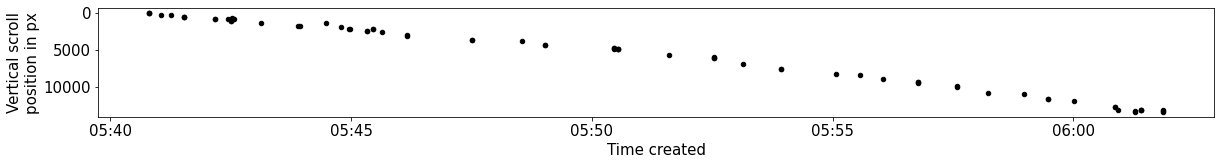

In [137]:
import matplotlib.dates as mdates
mpl.rcParams['figure.figsize'] = [20, 2]
d = df_scroll[(df_scroll.userid == 319)]
fig = d.plot.scatter("timecreated", "scrollTop", xlabel="Time created", ylabel="Vertical scroll\nposition in px", color="black")
fig.invert_yaxis()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))  
plt.rc('font', size=15)
plt.rc("axes", titlesize=15)
plt.rc("legend", fontsize=12)
plt.savefig("reading_scrolling.png", dpi=300, bbox_inches='tight')
fig

# Preprocessing quizzes

## Load and preprocess quiz attempts

In [138]:
df_attempts = pd.read_csv(subfolder + "mdl_quiz_attempts.csv", sep=";")
df_attempts

,id,quiz,userid,attempt,uniqueid,layout,currentpage,preview,state,timestart,timefinish,timemodified,timemodifiedoffline,timecheckstate,sumgrades
0,42,1,2,1,10078,"1,2,3,4,5,6,7,8,0",0,1,inprogress,1664895349,0,1665996205,0,NaN,NaN
1,44,1,72,1,10136,"1,2,3,4,5,6,7,8,0",0,0,finished,1665059043,1665059060,1665059060,0,NaN,3.88333
2,45,2,72,1,10187,"17,11,3,20,6,7,16,8,9,5,12,10,19,13,2,15,18,4,...",0,0,finished,1665059129,1665059163,1665059163,0,NaN,6.03333
3,46,1,74,1,10278,"1,2,3,4,5,6,7,8,0",0,0,finished,1665142156,1665142346,1665142346,0,NaN,2.75000
4,47,1,75,1,10323,"1,2,3,4,5,6,7,8,0",0,0,finished,1665148916,1665149932,1665149932,0,NaN,5.33333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,276,1,472,1,20437,"1,2,3,4,5,6,7,8,0",0,0,inprogress,1666861261,0,1666861270,0,NaN,NaN
234,277,1,473,1,20438,"1,2,3,4,5,6,7,8,0",0,0,finished,1666862532,1666862810,1666862810,0,NaN,7.00000
235,278,2,473,1,20526,"11,6,15,5,13,8,20,1,3,16,14,10,12,9,2,18,7,17,...",0,0,finished,1666863354,1666864489,1666864489,0,NaN,18.16667
236,279,1,474,1,20567,"1,2,3,4,5,6,7,8,0",0,0,finished,1666868131,1666868164,1666868164,0,NaN,2.41667


In [139]:
df_attempts["timestart"] = pd.to_datetime(df_attempts["timestart"], unit="s")
df_attempts["timefinish"] = pd.to_datetime(df_attempts["timefinish"], unit="s")
df_attempts["timemodified"] = pd.to_datetime(df_attempts["timemodified"], unit="s")
df_attempts = df_attempts[df_attempts.state == "finished"]
df_attempts

,id,quiz,userid,attempt,uniqueid,layout,currentpage,preview,state,timestart,timefinish,timemodified,timemodifiedoffline,timecheckstate,sumgrades
1,44,1,72,1,10136,"1,2,3,4,5,6,7,8,0",0,0,finished,2022-10-06 12:24:03,2022-10-06 12:24:20,2022-10-06 12:24:20,0,NaN,3.88333
2,45,2,72,1,10187,"17,11,3,20,6,7,16,8,9,5,12,10,19,13,2,15,18,4,...",0,0,finished,2022-10-06 12:25:29,2022-10-06 12:26:03,2022-10-06 12:26:03,0,NaN,6.03333
3,46,1,74,1,10278,"1,2,3,4,5,6,7,8,0",0,0,finished,2022-10-07 11:29:16,2022-10-07 11:32:26,2022-10-07 11:32:26,0,NaN,2.75000
4,47,1,75,1,10323,"1,2,3,4,5,6,7,8,0",0,0,finished,2022-10-07 13:21:56,2022-10-07 13:38:52,2022-10-07 13:38:52,0,NaN,5.33333
5,48,1,76,1,10382,"1,2,3,4,5,6,7,8,0",0,0,finished,2022-10-07 14:34:04,2022-10-07 14:38:27,2022-10-07 14:38:27,0,NaN,3.33333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,275,2,470,1,20405,"1,5,12,13,7,2,10,4,14,6,9,16,20,15,11,3,17,8,1...",0,0,finished,2022-10-27 05:58:17,2022-10-27 06:02:00,2022-10-27 06:02:00,0,NaN,10.16667
234,277,1,473,1,20438,"1,2,3,4,5,6,7,8,0",0,0,finished,2022-10-27 09:22:12,2022-10-27 09:26:50,2022-10-27 09:26:50,0,NaN,7.00000
235,278,2,473,1,20526,"11,6,15,5,13,8,20,1,3,16,14,10,12,9,2,18,7,17,...",0,0,finished,2022-10-27 09:35:54,2022-10-27 09:54:49,2022-10-27 09:54:49,0,NaN,18.16667
236,279,1,474,1,20567,"1,2,3,4,5,6,7,8,0",0,0,finished,2022-10-27 10:55:31,2022-10-27 10:56:04,2022-10-27 10:56:04,0,NaN,2.41667


In [140]:
df_quiz = pd.read_csv(subfolder + "mdl_quiz.csv", sep=";")
df_quiz = df_quiz[(df_quiz.course.isin(select_courses))]
df_quiz

,id,course,name,intro,introformat,timeopen,timeclose,timelimit,overduehandling,graceperiod,...,subnet,browsersecurity,delay1,delay2,showuserpicture,showblocks,completionattemptsexhausted,completionpass,completionminattempts,allowofflineattempts
0,1,2,2. Schritt: Vortest,"<p dir=""ltr"" style=""text-align: left;"">Bei die...",1,0,0,0,autosubmit,0,...,NaN,-,0,0,0,0,0,0,1,0
1,2,2,4. Schritt: Nachtest,"<p dir=""ltr"" style=""text-align: left;""></p><p ...",1,0,0,0,autosubmit,0,...,NaN,-,0,0,0,0,0,0,1,0


## Merge quiz and attempts

In [141]:
df_attempts = df_attempts.merge(df_quiz, left_on="quiz", right_on="id", suffixes=["_attempt", "_quiz"])
df_attempts["fraction"] = df_attempts["sumgrades_attempt"] / df_attempts["sumgrades_quiz"]
df_attempts

,id_attempt,quiz,userid,attempt,uniqueid,layout,currentpage,preview,state,timestart,...,browsersecurity,delay1,delay2,showuserpicture,showblocks,completionattemptsexhausted,completionpass,completionminattempts,allowofflineattempts,fraction
0,44,1,72,1,10136,"1,2,3,4,5,6,7,8,0",0,0,finished,2022-10-06 12:24:03,...,-,0,0,0,0,0,0,1,0,0.485416
1,46,1,74,1,10278,"1,2,3,4,5,6,7,8,0",0,0,finished,2022-10-07 11:29:16,...,-,0,0,0,0,0,0,1,0,0.343750
2,47,1,75,1,10323,"1,2,3,4,5,6,7,8,0",0,0,finished,2022-10-07 13:21:56,...,-,0,0,0,0,0,0,1,0,0.666666
3,48,1,76,1,10382,"1,2,3,4,5,6,7,8,0",0,0,finished,2022-10-07 14:34:04,...,-,0,0,0,0,0,0,1,0,0.416666
4,49,1,78,1,10482,"1,2,3,4,5,6,7,8,0",0,0,finished,2022-10-09 17:21:11,...,-,0,0,0,0,0,0,1,0,0.677084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,269,2,459,1,20182,"4,6,18,1,8,17,11,15,13,16,14,19,9,7,2,5,20,12,...",0,0,finished,2022-10-26 13:22:47,...,-,0,0,0,0,0,0,1,0,0.674167
186,272,2,464,1,20256,"9,7,19,1,20,12,3,4,17,11,14,2,6,10,18,13,15,8,...",0,0,finished,2022-10-26 16:38:24,...,-,0,0,0,0,0,0,1,0,0.404166
187,275,2,470,1,20405,"1,5,12,13,7,2,10,4,14,6,9,16,20,15,11,3,17,8,1...",0,0,finished,2022-10-27 05:58:17,...,-,0,0,0,0,0,0,1,0,0.508333
188,278,2,473,1,20526,"11,6,15,5,13,8,20,1,3,16,14,10,12,9,2,18,7,17,...",0,0,finished,2022-10-27 09:35:54,...,-,0,0,0,0,0,0,1,0,0.908334


## Find users that finished posttest

In [142]:
usersfinished = df_attempts[df_attempts["quiz"] == posttestid]["userid"]
usersfinished

117     72
118     87
119    111
120    137
121    153
      ... 
185    459
186    464
187    470
188    473
189    474
Name: userid, Length: 73, dtype: int64

## Join groups to users in attempts

In [143]:
df_attempts = df_attempts.merge(df_groupmembers[["groupid", "userid"]], on="userid", how="left")
df_attempts

,id_attempt,quiz,userid,attempt,uniqueid,layout,currentpage,preview,state,timestart,...,delay1,delay2,showuserpicture,showblocks,completionattemptsexhausted,completionpass,completionminattempts,allowofflineattempts,fraction,groupid
0,44,1,72,1,10136,"1,2,3,4,5,6,7,8,0",0,0,finished,2022-10-06 12:24:03,...,0,0,0,0,0,0,1,0,0.485416,1.0
1,46,1,74,1,10278,"1,2,3,4,5,6,7,8,0",0,0,finished,2022-10-07 11:29:16,...,0,0,0,0,0,0,1,0,0.343750,1.0
2,47,1,75,1,10323,"1,2,3,4,5,6,7,8,0",0,0,finished,2022-10-07 13:21:56,...,0,0,0,0,0,0,1,0,0.666666,2.0
3,48,1,76,1,10382,"1,2,3,4,5,6,7,8,0",0,0,finished,2022-10-07 14:34:04,...,0,0,0,0,0,0,1,0,0.416666,2.0
4,49,1,78,1,10482,"1,2,3,4,5,6,7,8,0",0,0,finished,2022-10-09 17:21:11,...,0,0,0,0,0,0,1,0,0.677084,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,269,2,459,1,20182,"4,6,18,1,8,17,11,15,13,16,14,19,9,7,2,5,20,12,...",0,0,finished,2022-10-26 13:22:47,...,0,0,0,0,0,0,1,0,0.674167,2.0
186,272,2,464,1,20256,"9,7,19,1,20,12,3,4,17,11,14,2,6,10,18,13,15,8,...",0,0,finished,2022-10-26 16:38:24,...,0,0,0,0,0,0,1,0,0.404166,1.0
187,275,2,470,1,20405,"1,5,12,13,7,2,10,4,14,6,9,16,20,15,11,3,17,8,1...",0,0,finished,2022-10-27 05:58:17,...,0,0,0,0,0,0,1,0,0.508333,2.0
188,278,2,473,1,20526,"11,6,15,5,13,8,20,1,3,16,14,10,12,9,2,18,7,17,...",0,0,finished,2022-10-27 09:35:54,...,0,0,0,0,0,0,1,0,0.908334,1.0


# Preprocessing quiz questions

In [144]:
df_questions = pd.read_csv(subfolder + "mdl_question_attempt_steps.csv", sep=";")\
                    .merge(pd.read_csv(subfolder + "mdl_question_attempts.csv", sep=";"), left_on="questionattemptid", right_on="id", how="left")\
                    .merge(pd.read_csv(subfolder + "mdl_question_usages.csv", sep=";"), left_on="questionusageid", right_on="id", how="left")
df_questions

,id_x,questionattemptid,sequencenumber,state,fraction,timecreated,userid,id_y,questionusageid,slot,...,maxfraction,flagged,questionsummary,rightanswer,responsesummary,timemodified,id,contextid,component,preferredbehaviour
0,11429,10539,0,todo,NaN,1664895349,2,10539,10078,1,...,1.0,0,Wie lässt sich Learning Analytics definieren?\...,"Sammlung, Analyse, Nutzung und Bereitstellung ...",NaN,1665996205,10078,41,mod_quiz,deferredfeedback
1,11430,10540,0,todo,NaN,1664895349,2,10540,10078,2,...,1.0,0,Welche Zwecke von Learning Analytics dienen pr...,Wahrung der Studierendenidentität und -individ...,NaN,1665996205,10078,41,mod_quiz,deferredfeedback
2,11431,10541,0,todo,NaN,1664895349,2,10541,10078,3,...,1.0,0,Inwiefern kann man von einer Verpflichtung von...,"Insofern, dass Bildungsinstitutionen ethisch v...",NaN,1665996205,10078,41,mod_quiz,deferredfeedback
3,11432,10542,0,todo,NaN,1664895349,2,10542,10078,4,...,1.0,0,"Warum ist es wichtig, wie die Studierenden Zwe...",Um positive Beziehungen zu den Studierenden zu...,NaN,1665996205,10078,41,mod_quiz,deferredfeedback
4,11433,10543,0,todo,NaN,1664895349,2,10543,10078,5,...,1.0,0,"Warum ist es für Lerninstitutionen schwierig, ...",Aus der riesigen Menge an Aktivitätsdaten müss...,NaN,1665996205,10078,41,mod_quiz,deferredfeedback
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7817,32639,23662,2,gradedwrong,0.000000,1666868283,474,23662,20619,17,...,1.0,0,"Welche Gefahr besteht, wenn Learning Analytics...",Dass Studierende als passive Datenproduzenten ...,Dass es in erster Linie dem Lernen dient\n\n,1666868284,20619,55,mod_quiz,deferredfeedback
7818,32640,23663,2,gradedpartial,0.250000,1666868283,474,23663,20619,18,...,1.0,0,Welche Zwecke von Learning Analytics dienen pr...,Wahrung der Studierendenidentität und -individ...,Studienförderung\n\n,1666868284,20619,55,mod_quiz,deferredfeedback
7819,32641,23664,2,gradedpartial,0.333333,1666868283,474,23664,20619,19,...,1.0,0,Welche Zwecke von Learning Analytics werden im...,Gewinne der Einrichtung maximieren\n\n; Maximi...,Maximierung der Abschlussquoten von Benachteil...,1666868284,20619,55,mod_quiz,deferredfeedback
7820,32642,23665,2,gradedpartial,0.500000,1666868283,474,23665,20619,20,...,1.0,0,Wie könnten sowohl das Potenzial von Learning ...,Indem sowohl der Zugang zu Datensätzen (z. B. ...,Indem sowohl der Zugang zu Datensätzen (z. B. ...,1666868284,20619,55,mod_quiz,deferredfeedback


## Join groups to users in questions

In [145]:
df_questions = df_questions.merge(df_groupmembers[["groupid", "userid"]], on="userid", how="left")
df_questions

,id_x,questionattemptid,sequencenumber,state,fraction,timecreated,userid,id_y,questionusageid,slot,...,flagged,questionsummary,rightanswer,responsesummary,timemodified,id,contextid,component,preferredbehaviour,groupid
0,11429,10539,0,todo,NaN,1664895349,2,10539,10078,1,...,0,Wie lässt sich Learning Analytics definieren?\...,"Sammlung, Analyse, Nutzung und Bereitstellung ...",NaN,1665996205,10078,41,mod_quiz,deferredfeedback,NaN
1,11430,10540,0,todo,NaN,1664895349,2,10540,10078,2,...,0,Welche Zwecke von Learning Analytics dienen pr...,Wahrung der Studierendenidentität und -individ...,NaN,1665996205,10078,41,mod_quiz,deferredfeedback,NaN
2,11431,10541,0,todo,NaN,1664895349,2,10541,10078,3,...,0,Inwiefern kann man von einer Verpflichtung von...,"Insofern, dass Bildungsinstitutionen ethisch v...",NaN,1665996205,10078,41,mod_quiz,deferredfeedback,NaN
3,11432,10542,0,todo,NaN,1664895349,2,10542,10078,4,...,0,"Warum ist es wichtig, wie die Studierenden Zwe...",Um positive Beziehungen zu den Studierenden zu...,NaN,1665996205,10078,41,mod_quiz,deferredfeedback,NaN
4,11433,10543,0,todo,NaN,1664895349,2,10543,10078,5,...,0,"Warum ist es für Lerninstitutionen schwierig, ...",Aus der riesigen Menge an Aktivitätsdaten müss...,NaN,1665996205,10078,41,mod_quiz,deferredfeedback,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7817,32639,23662,2,gradedwrong,0.000000,1666868283,474,23662,20619,17,...,0,"Welche Gefahr besteht, wenn Learning Analytics...",Dass Studierende als passive Datenproduzenten ...,Dass es in erster Linie dem Lernen dient\n\n,1666868284,20619,55,mod_quiz,deferredfeedback,2.0
7818,32640,23663,2,gradedpartial,0.250000,1666868283,474,23663,20619,18,...,0,Welche Zwecke von Learning Analytics dienen pr...,Wahrung der Studierendenidentität und -individ...,Studienförderung\n\n,1666868284,20619,55,mod_quiz,deferredfeedback,2.0
7819,32641,23664,2,gradedpartial,0.333333,1666868283,474,23664,20619,19,...,0,Welche Zwecke von Learning Analytics werden im...,Gewinne der Einrichtung maximieren\n\n; Maximi...,Maximierung der Abschlussquoten von Benachteil...,1666868284,20619,55,mod_quiz,deferredfeedback,2.0
7820,32642,23665,2,gradedpartial,0.500000,1666868283,474,23665,20619,20,...,0,Wie könnten sowohl das Potenzial von Learning ...,Indem sowohl der Zugang zu Datensätzen (z. B. ...,Indem sowohl der Zugang zu Datensätzen (z. B. ...,1666868284,20619,55,mod_quiz,deferredfeedback,2.0


# Processing adjunct questions

In [146]:
df_adjunct = df_log[(df_log.component == "filter_embedquestion") & (df_log.action == "attempted")]
df_adjunct

,Unnamed: 0,id,eventname,component,action,target,objecttable,objectid,crud,edulevel,...,contextlevel,contextinstanceid,userid,courseid,relateduserid,anonymous,other,timecreated,origin,realuserid
1370,1370,1371,\filter_embedquestion\event\question_attempted,filter_embedquestion,attempted,question,question,1.0,u,2,...,70,2,2,2,NaN,0,NaN,2022-07-11 09:11:30,web,NaN
1442,1442,1443,\filter_embedquestion\event\question_attempted,filter_embedquestion,attempted,question,question,2.0,u,2,...,70,2,2,2,NaN,0,NaN,2022-07-11 09:27:00,web,NaN
1520,1520,1521,\filter_embedquestion\event\question_attempted,filter_embedquestion,attempted,question,question,2.0,u,2,...,70,2,2,2,NaN,0,NaN,2022-07-11 09:30:00,web,NaN
1586,1586,1587,\filter_embedquestion\event\question_attempted,filter_embedquestion,attempted,question,question,3.0,u,2,...,70,2,2,2,NaN,0,NaN,2022-07-11 14:38:52,web,NaN
1662,1662,1663,\filter_embedquestion\event\question_attempted,filter_embedquestion,attempted,question,question,5.0,u,2,...,70,2,2,2,NaN,0,NaN,2022-07-11 14:58:56,web,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66850,66850,66851,\filter_embedquestion\event\question_attempted,filter_embedquestion,attempted,question,question,18.0,u,2,...,70,11,470,2,NaN,0,NaN,2022-10-27 05:57:05,web,NaN
66855,66855,66856,\filter_embedquestion\event\question_attempted,filter_embedquestion,attempted,question,question,19.0,u,2,...,70,11,470,2,NaN,0,NaN,2022-10-27 05:57:59,web,NaN
67590,67590,67591,\filter_embedquestion\event\question_attempted,filter_embedquestion,attempted,question,question,18.0,u,2,...,70,11,474,2,NaN,0,NaN,2022-10-27 10:56:45,web,NaN
67601,67601,67602,\filter_embedquestion\event\question_attempted,filter_embedquestion,attempted,question,question,16.0,u,2,...,70,11,474,2,NaN,0,NaN,2022-10-27 10:56:55,web,NaN


In [147]:
df_adjunct = df_adjunct.merge(df_groupmembers[["groupid", "userid"]], on="userid", how="left")
df_adjunct

,Unnamed: 0,id,eventname,component,action,target,objecttable,objectid,crud,edulevel,...,contextinstanceid,userid,courseid,relateduserid,anonymous,other,timecreated,origin,realuserid,groupid
0,1370,1371,\filter_embedquestion\event\question_attempted,filter_embedquestion,attempted,question,question,1.0,u,2,...,2,2,2,NaN,0,NaN,2022-07-11 09:11:30,web,NaN,NaN
1,1442,1443,\filter_embedquestion\event\question_attempted,filter_embedquestion,attempted,question,question,2.0,u,2,...,2,2,2,NaN,0,NaN,2022-07-11 09:27:00,web,NaN,NaN
2,1520,1521,\filter_embedquestion\event\question_attempted,filter_embedquestion,attempted,question,question,2.0,u,2,...,2,2,2,NaN,0,NaN,2022-07-11 09:30:00,web,NaN,NaN
3,1586,1587,\filter_embedquestion\event\question_attempted,filter_embedquestion,attempted,question,question,3.0,u,2,...,2,2,2,NaN,0,NaN,2022-07-11 14:38:52,web,NaN,NaN
4,1662,1663,\filter_embedquestion\event\question_attempted,filter_embedquestion,attempted,question,question,5.0,u,2,...,2,2,2,NaN,0,NaN,2022-07-11 14:58:56,web,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,66850,66851,\filter_embedquestion\event\question_attempted,filter_embedquestion,attempted,question,question,18.0,u,2,...,11,470,2,NaN,0,NaN,2022-10-27 05:57:05,web,NaN,2.0
1148,66855,66856,\filter_embedquestion\event\question_attempted,filter_embedquestion,attempted,question,question,19.0,u,2,...,11,470,2,NaN,0,NaN,2022-10-27 05:57:59,web,NaN,2.0
1149,67590,67591,\filter_embedquestion\event\question_attempted,filter_embedquestion,attempted,question,question,18.0,u,2,...,11,474,2,NaN,0,NaN,2022-10-27 10:56:45,web,NaN,2.0
1150,67601,67602,\filter_embedquestion\event\question_attempted,filter_embedquestion,attempted,question,question,16.0,u,2,...,11,474,2,NaN,0,NaN,2022-10-27 10:56:55,web,NaN,2.0


# Preprocessing questionnaire

In [148]:
df_questionnaire = pd.read_csv(subfolder + "mdl_questionnaire_resp_single.csv", sep=";")\
        .merge(pd.read_csv(subfolder + "mdl_questionnaire_quest_choice.csv", sep=";"), left_on="choice_id", right_on="id")\
        .merge(pd.read_csv(subfolder + "mdl_questionnaire_response.csv", sep=";"), left_on="response_id", right_on="id")
df_questionnaire

,id_x,response_id,question_id_x,choice_id,id_y,question_id_y,content,value,id,questionnaireid,submitted,complete,grade,userid
0,58,20,4,8,8,4,18-20,NaN,20,2,1665059039,y,0,72
1,59,20,5,15,15,5,Männlich,NaN,20,2,1665059039,y,0,72
2,60,20,6,20,20,6,Gymnasium (Abitur),NaN,20,2,1665059039,y,0,72
3,256,86,4,8,8,4,18-20,NaN,86,2,1666266137,y,0,259
4,258,86,6,20,20,6,Gymnasium (Abitur),NaN,86,2,1666266137,y,0,259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,532,178,4,12,12,4,50-59,NaN,178,2,1666805274,y,0,465
485,534,178,6,28,28,6,Andere,NaN,178,2,1666805274,y,0,465
486,536,179,5,14,14,5,Weiblich,NaN,179,2,1666847560,y,0,470
487,535,179,4,11,11,4,40-49,NaN,179,2,1666847560,y,0,470


# Preprocessing question statistics

In [149]:
df_question_stats = pd.read_csv(subfolder + "mdl_question_statistics.csv", sep=";")
df_question_stats = df_question_stats[df_question_stats.hashcode == "b441fd04c486a59f671bc8ce193be3acf87e8aed"]
df_question_stats

,id,hashcode,timemodified,questionid,slot,subquestion,variant,s,effectiveweight,negcovar,discriminationindex,discriminativeefficiency,sd,facility,subquestions,maxmark,positions,randomguessscore
0,908,b441fd04c486a59f671bc8ce193be3acf87e8aed,1666941648,20,1,0,NaN,73,4.03012,0,38.28559,42.35385,0.256655,0.607306,NaN,1.0,1,NaN
1,909,b441fd04c486a59f671bc8ce193be3acf87e8aed,1666941648,1,2,0,NaN,73,5.53130,0,34.51480,41.37362,0.467758,0.684932,NaN,1.0,2,0.25
2,910,b441fd04c486a59f671bc8ce193be3acf87e8aed,1666941649,2,3,0,NaN,73,5.51042,0,35.76499,44.06730,0.455810,0.712329,NaN,1.0,3,0.50
3,911,b441fd04c486a59f671bc8ce193be3acf87e8aed,1666941649,4,4,0,NaN,73,5.17194,0,51.49905,58.24478,0.323190,0.440639,NaN,1.0,4,NaN
4,912,b441fd04c486a59f671bc8ce193be3acf87e8aed,1666941649,5,5,0,NaN,73,3.87569,0,39.31581,64.14334,0.234894,0.938356,NaN,1.0,5,NaN
5,913,b441fd04c486a59f671bc8ce193be3acf87e8aed,1666941649,9,6,0,NaN,73,4.28871,0,40.20202,62.82346,0.276557,0.917808,NaN,1.0,6,0.50
6,914,b441fd04c486a59f671bc8ce193be3acf87e8aed,1666941649,10,7,0,NaN,73,5.39469,0,66.32201,71.01322,0.288428,0.606164,NaN,1.0,7,NaN
7,915,b441fd04c486a59f671bc8ce193be3acf87e8aed,1666941649,6,8,0,NaN,73,5.08882,0,43.74863,47.94230,0.351935,0.505479,NaN,1.0,8,NaN
8,916,b441fd04c486a59f671bc8ce193be3acf87e8aed,1666941649,17,9,0,NaN,73,5.79761,0,73.04824,78.11124,0.306303,0.613014,NaN,1.0,9,NaN
9,917,b441fd04c486a59f671bc8ce193be3acf87e8aed,1666941649,11,10,0,NaN,73,5.28654,0,64.38880,72.49432,0.284192,0.808219,NaN,1.0,10,NaN


## Join groups to questionnaire

In [150]:
df_questionnaire = df_questionnaire.merge(df_groupmembers[["groupid", "userid"]], on="userid", how="left")
df_questionnaire

,id_x,response_id,question_id_x,choice_id,id_y,question_id_y,content,value,id,questionnaireid,submitted,complete,grade,userid,groupid
0,58,20,4,8,8,4,18-20,NaN,20,2,1665059039,y,0,72,1.0
1,59,20,5,15,15,5,Männlich,NaN,20,2,1665059039,y,0,72,1.0
2,60,20,6,20,20,6,Gymnasium (Abitur),NaN,20,2,1665059039,y,0,72,1.0
3,256,86,4,8,8,4,18-20,NaN,86,2,1666266137,y,0,259,2.0
4,258,86,6,20,20,6,Gymnasium (Abitur),NaN,86,2,1666266137,y,0,259,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,532,178,4,12,12,4,50-59,NaN,178,2,1666805274,y,0,465,2.0
485,534,178,6,28,28,6,Andere,NaN,178,2,1666805274,y,0,465,2.0
486,536,179,5,14,14,5,Weiblich,NaN,179,2,1666847560,y,0,470,2.0
487,535,179,4,11,11,4,40-49,NaN,179,2,1666847560,y,0,470,2.0


# Filter users

## Filter users that are not participants

In [151]:
df_scroll = df_scroll[(~df_scroll.userid.isin(no_students))]

## Users that started questionnaire

In [152]:
df_questionnaire.userid.nunique()

163

## Users that finished pretest

In [153]:
df_attempts[(df_attempts["quiz"] == pretestid) & (~df_attempts.userid.isin(no_students))]["userid"].nunique()

116

In [154]:
df_attempts[df_attempts["quiz"] == pretestid].groupby("quiz")["fraction"].mean()

quiz
1    0.549145
Name: fraction, dtype: float64

## Filter students with reading time less than 10 min

In [155]:
minMinutes = 10

In [156]:
df_scroll["userid"].nunique()

111

In [157]:
df_scroll.groupby("groupid")["userid"].nunique()

groupid
1.0    58
2.0    53
Name: userid, dtype: int64

<AxesSubplot:>

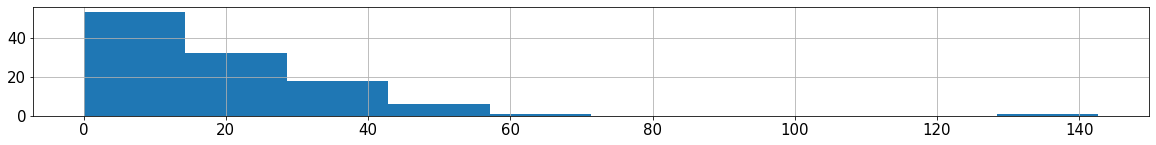

In [158]:
(df_scroll.groupby(["userid"])["relativeTime"].max() / 60000).hist()

groupid
0.000017    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
0.000033    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

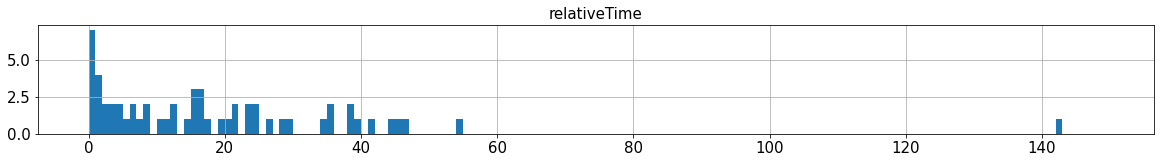

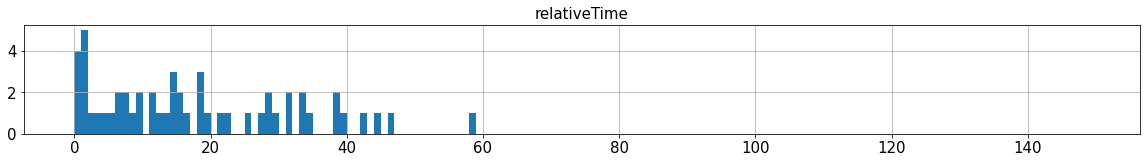

In [159]:
grp = (df_scroll.select_dtypes(include=np.number).groupby(["userid"]).max() / 60000).groupby("groupid")
grp.hist("relativeTime", bins=range(0,150))

In [160]:
levene(grp.get_group(1/ 60000)["relativeTime"], grp.get_group(2/ 60000)["relativeTime"]), ttest_ind(grp.get_group(1/ 60000)["relativeTime"], grp.get_group(2/ 60000)["relativeTime"])

(LeveneResult(statistic=0.6955270981979713, pvalue=0.40611469853418636),
 Ttest_indResult(statistic=0.32773980872656816, pvalue=0.743737068275746))

In [161]:
df_scroll[df_scroll.groupby(["userid"])["relativeTime"].transform(lambda x: x.max() >= minMinutes*60000)]["userid"].nunique()

68

In [162]:
df_scroll = df_scroll[df_scroll.groupby(["userid"])["relativeTime"].transform(lambda x: x.max() >= minMinutes*60000)]

### All tables

In [163]:
df_adjunct = df_adjunct[df_adjunct.userid.isin(df_scroll.userid)]
df_attempts = df_attempts[df_attempts.userid.isin(df_scroll.userid)]
df_groupmembers = df_groupmembers[df_groupmembers.userid.isin(df_scroll.userid)]
df_log = df_log[df_log.userid.isin(df_scroll.userid)]
df_questionnaire = df_questionnaire[df_questionnaire.userid.isin(df_scroll.userid)]
df_questions = df_questions[df_questions.userid.isin(df_scroll.userid)]

# Descriptive statistics

## Readability

In [164]:
import textstat
textstat.set_lang("de")
textstat.flesch_reading_ease("Study text.txt"), textstat.wiener_sachtextformel("Study text.txt", 1)

(61.0, 5.9)

## Number of logs

In [165]:
df_scroll.size, df_questions.size, sum([df_scroll.size, df_questions.size])

(306891, 131612, 438503)

## Questionnaire

## Age

### Distribution

<AxesSubplot:>

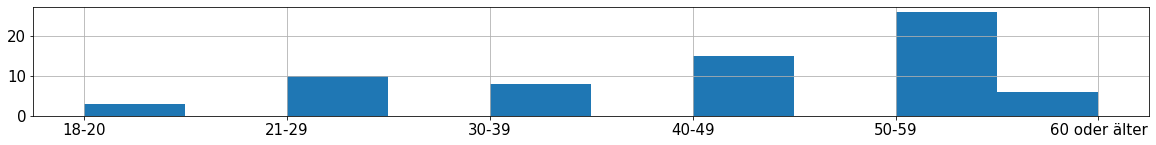

In [166]:
df_questionnaire[df_questionnaire.question_id_x == questionnaire_ageid].sort_values(by="choice_id")["content"].hist()

array([<AxesSubplot:title={'center':'1.0'}>,
       <AxesSubplot:title={'center':'2.0'}>], dtype=object)

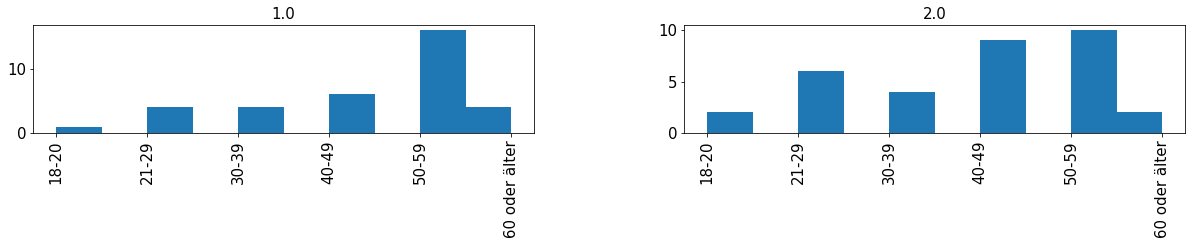

In [167]:
df_questionnaire[df_questionnaire.question_id_x == questionnaire_ageid].sort_values(by="choice_id").hist(column="content", by="groupid")

### Mean

In [168]:
age = df_questionnaire[df_questionnaire.question_id_x == questionnaire_ageid]["content"].replace({"18-20":19, "21-29":25, "30-39":35, "40-49":45, "50-59":55, "60 oder älter":65})
age.mean(), age.std()

(45.3235294117647, 13.282736159942512)

In [169]:
grp = df_questionnaire[df_questionnaire.question_id_x == questionnaire_ageid].replace({"18-20":19, "21-29":25, "30-39":35, "40-49":45, "50-59":55, "60 oder älter":65}).groupby("groupid")["content"]
grp.mean(), grp.std()

(groupid
 1.0    47.685714
 2.0    42.818182
 Name: content, dtype: float64,
 groupid
 1.0    12.860728
 2.0    13.457002
 Name: content, dtype: float64)

In [170]:
levene(grp.get_group(1), grp.get_group(2)), ttest_ind(grp.get_group(1), grp.get_group(2))

(LeveneResult(statistic=0.19720701012325423, pvalue=0.6584374198542149),
 Ttest_indResult(statistic=1.5251541692034172, pvalue=0.13199859682727533))

## Education

<AxesSubplot:>

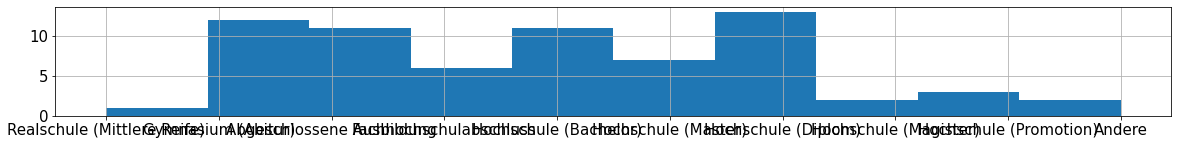

In [171]:
df_questionnaire[df_questionnaire.question_id_x == questionnaire_educationid].sort_values(by="choice_id")["content"].hist()

array([<AxesSubplot:title={'center':'1.0'}>,
       <AxesSubplot:title={'center':'2.0'}>], dtype=object)

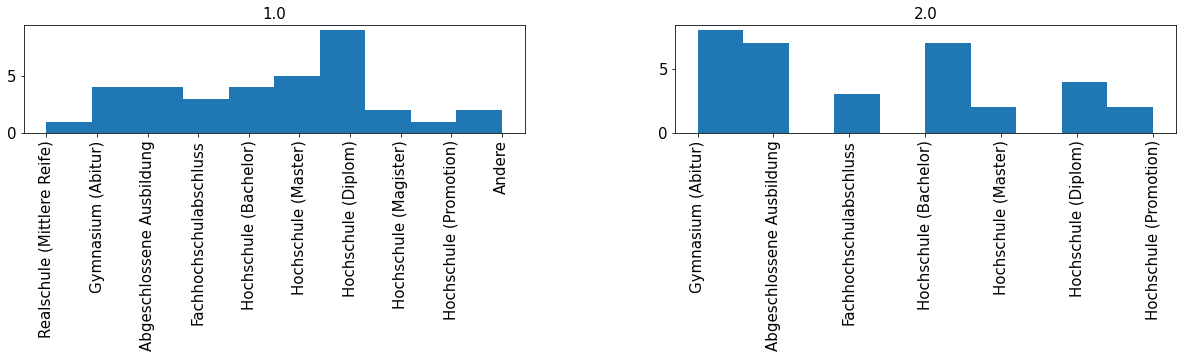

In [172]:
df_questionnaire[df_questionnaire.question_id_x == questionnaire_educationid].sort_values(by="choice_id").hist(column="content", by="groupid")

In [173]:
grp = df_questionnaire[df_questionnaire.question_id_x == questionnaire_educationid].replace(
    {
        "Kein Schulabschluss": 1, 
        "Grund-/Hauptschullabschluss": 2,
        "Realschule (Mittlere Reife)": 3,
        "Abgeschlossene Ausbildung": 4,
        "Gymnasium (Abitur)": 5,
        "Fachhochschulabschluss": 6,
        "Hochschule (Bachelor)": 7,
        "Hochschule (Master)": 8,
        "Hochschule (Diplom)": 8,
        "Hochschule (Magister)": 8,
        "Hochschule (Promotion)": 9,
        "Andere": 4,
    }).groupby("groupid")["content"]
grp.mean(), mannwhitneyu(grp.get_group(1), grp.get_group(2))

(groupid
 1.0    6.571429
 2.0    6.090909
 Name: content, dtype: float64,
 MannwhitneyuResult(statistic=680.5, pvalue=0.19662726736026215))

## Gender

content
Anderes      1
Männlich    19
Weiblich    48
Name: id, dtype: int64

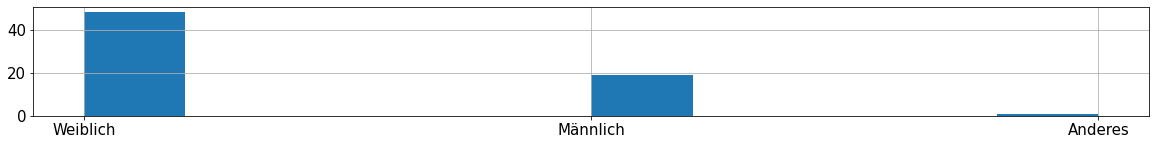

In [174]:
df_questionnaire[df_questionnaire.question_id_x == questionnaire_genderid].sort_values(by="choice_id")["content"].hist(), 
df_questionnaire[df_questionnaire.question_id_x == questionnaire_genderid].groupby("content")["id"].count()

array([<AxesSubplot:title={'center':'1.0'}>,
       <AxesSubplot:title={'center':'2.0'}>], dtype=object)

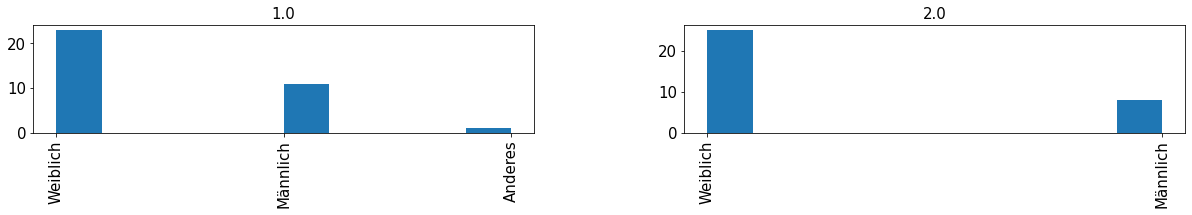

In [175]:
df_questionnaire[df_questionnaire.question_id_x == questionnaire_genderid].sort_values(by="choice_id").hist(column="content", by="groupid")

In [176]:
chisquare([grp.get_group(1).filter(like="Männlich").sum()/grp.get_group(1).filter(regex="Männlich|Weiblich").sum(),grp.get_group(1).filter(like="Weiblich").sum()/grp.get_group(1).filter(regex="Männlich|Weiblich").sum()], 
f_exp=[grp.get_group(2).filter(like="Männlich").sum()/grp.get_group(2).filter(regex="Männlich|Weiblich").sum(),grp.get_group(2).filter(like="Weiblich").sum()/grp.get_group(2).filter(regex="Männlich|Weiblich").sum()])

C:\Users\menze\AppData\Local\Temp/ipykernel_1084/2159881363.py:1: RuntimeWarning: invalid value encountered in longlong_scalars
  chisquare([grp.get_group(1).filter(like="Männlich").sum()/grp.get_group(1).filter(regex="Männlich|Weiblich").sum(),grp.get_group(1).filter(like="Weiblich").sum()/grp.get_group(1).filter(regex="Männlich|Weiblich").sum()],
C:\Users\menze\AppData\Local\Temp/ipykernel_1084/2159881363.py:2: RuntimeWarning: invalid value encountered in longlong_scalars
  f_exp=[grp.get_group(2).filter(like="Männlich").sum()/grp.get_group(2).filter(regex="Männlich|Weiblich").sum(),grp.get_group(2).filter(like="Weiblich").sum()/grp.get_group(2).filter(regex="Männlich|Weiblich").sum()])


Power_divergenceResult(statistic=nan, pvalue=nan)

## Time of day, day of week

<AxesSubplot:>

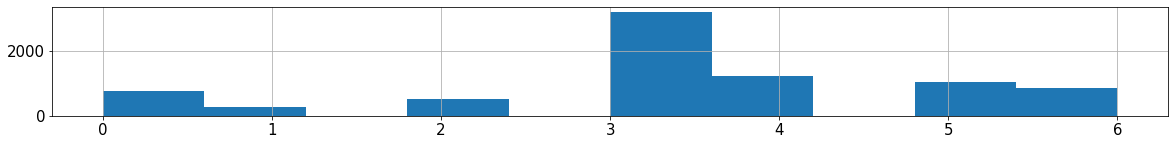

In [177]:
df_scroll.timecreated.dt.day_of_week.hist()

<AxesSubplot:>

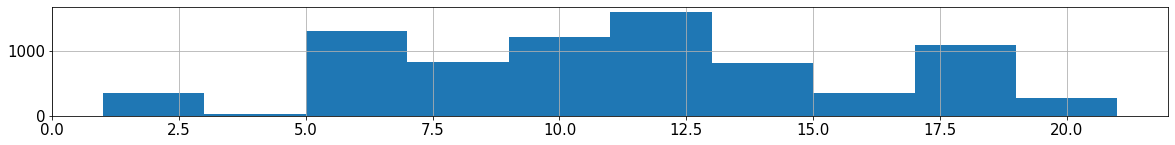

In [178]:
df_scroll.timecreated.dt.hour.hist()

## Users per group

In [179]:
df_scroll.groupby("groupid")["userid"].nunique()

groupid
1.0    35
2.0    33
Name: userid, dtype: int64

## Users per group that finished posttest

In [180]:
n_exp, n_cont = df_scroll[df_scroll["userid"].isin(usersfinished)].groupby("groupid")["userid"].nunique()
n_exp, n_cont 

(28, 29)

## Time on page per user

In [181]:
df_scroll.groupby(["userid"])["relativeTime"].max() / 60000

userid
76     18.859048
111    33.354448
137    28.186258
139    38.801818
140    41.671042
         ...    
456    21.548133
457    11.037210
459    14.608170
461    24.498496
470    34.907800
Name: relativeTime, Length: 68, dtype: float64

In [182]:
grp = df_scroll.groupby("userid").max()["relativeTime"] 
grp.mean() / 60000, grp.std() / 60000

(28.029383269607884, 18.369256593443758)

## Users time on page per group

In [183]:
grp = df_scroll.groupby("userid").max().groupby("groupid")["relativeTime"] 
grp.mean() / 60000, grp.std() / 60000

(groupid
 1.0    29.561685
 2.0    26.404215
 Name: relativeTime, dtype: float64,
 groupid
 1.0    22.948829
 2.0    11.901140
 Name: relativeTime, dtype: float64)

In [184]:
levene(grp.get_group(1), grp.get_group(2)), ttest_ind(grp.get_group(1), grp.get_group(2))

(LeveneResult(statistic=0.688717851109911, pvalue=0.4095925769887966),
 Ttest_indResult(statistic=0.7057508012861375, pvalue=0.482826826707315))

## Max sections per group

In [185]:
grp = df_scroll.groupby("userid").max().groupby("groupid")["paragraph"]
grp.mean(), grp.std()

(groupid
 1.0    56.285714
 2.0    57.606061
 Name: paragraph, dtype: float64,
 groupid
 1.0    10.942554
 2.0     7.101670
 Name: paragraph, dtype: float64)

In [186]:
levene(grp.get_group(1), grp.get_group(2)), ttest_ind(grp.get_group(1), grp.get_group(2))

(LeveneResult(statistic=0.343764165682721, pvalue=0.5596644559621549),
 Ttest_indResult(statistic=-0.5863140503882908, pvalue=0.5596644559621493))

### In pixels

In [187]:
df_scroll["scrollTop"].max()


84475.5

### Percentage of page read

In [188]:
df_scroll.groupby("userid").max()["paragraph"].mean() / 60#=df_scroll["paragraph"].max()

0.9487745098039216

In [189]:
df_scroll.groupby("userid").max()["paragraph"].std() / 60# df_scroll["paragraph"].mean()

0.15392370060912922

## Number of scroll events per group

In [190]:
df_scroll.groupby("groupid")["id"].count()

groupid
1.0    4046
2.0    3823
Name: id, dtype: int64

### Per User

In [191]:
grp = df_scroll.groupby(["userid", "groupid"]).count().groupby("groupid")["id"]
grp.mean(), grp.std()

(groupid
 1.0    115.600000
 2.0    115.848485
 Name: id, dtype: float64,
 groupid
 1.0    74.269066
 2.0    67.773115
 Name: id, dtype: float64)

In [192]:
levene(grp.get_group(1), grp.get_group(2)), ttest_ind(grp.get_group(1), grp.get_group(2))

(LeveneResult(statistic=0.16901570341920472, pvalue=0.6823199294861673),
 Ttest_indResult(statistic=-0.0143845293503143, pvalue=0.9885665967108619))

## Mean time per scroll event

In [193]:
grp = df_scroll.groupby(["userid", "groupid"])["relativeTime"]

grp = (grp.count() / (grp.max()/1000)).groupby("groupid")
grp.mean(), grp.std()


(groupid
 1.0    0.087756
 2.0    0.088548
 Name: relativeTime, dtype: float64,
 groupid
 1.0    0.078355
 2.0    0.063947
 Name: relativeTime, dtype: float64)

In [194]:
levene(grp.get_group(1), grp.get_group(2)), ttest_ind(grp.get_group(1), grp.get_group(2))

(LeveneResult(statistic=0.11847806326348649, pvalue=0.7317853516169879),
 Ttest_indResult(statistic=-0.045476362299004695, pvalue=0.9638649343677581))

## Scroll speed

<AxesSubplot:>

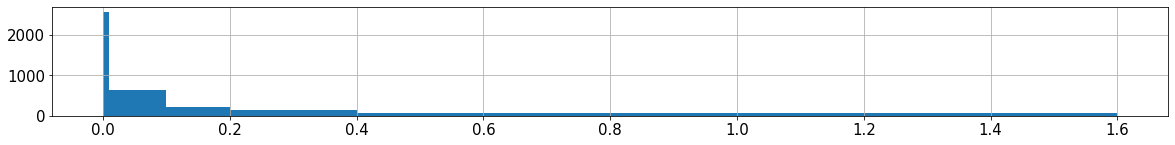

In [195]:
res = df_scroll[["relativeTime","userid", "groupid"]].set_index(["userid", "groupid"]).diff().fillna(value=0)["relativeTime"] / 1000
res[res < 0 ] = 0
#res = df_scroll[["targetHeight","userid", "groupid"]].set_index(["userid", "groupid"])["targetHeight"]
res = (res / df_scroll[["targetHeight","userid", "groupid"]].set_index(["userid", "groupid"])["targetHeight"])
res.replace([np.inf, -np.inf], np.nan, inplace=True)
res = res[(res.notna())]
res.groupby("groupid").get_group(1).hist(bins=[0,0.01,0.1,0.2,0.4,0.8,1.6])


<AxesSubplot:>

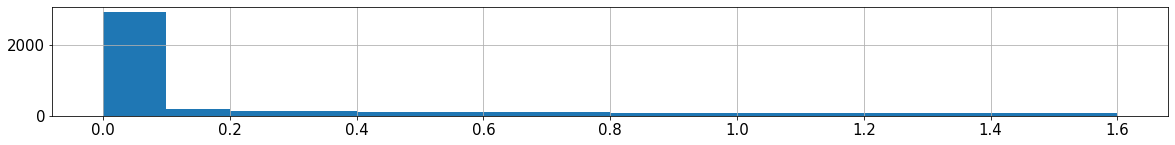

In [196]:
res.groupby("groupid").get_group(2).hist(bins=[0,0.1,0.2,0.4,0.8,1.6])


In [197]:
res.median()

0.003086296296294744

## Question attempts and score during reading per group

### Answers per user in percent

In [198]:
grp = df_adjunct.groupby(["userid"]).count()["objectid"]
grp.mean() / 20, grp.std() / 20

(0.9390909090909091, 0.4456259547899917)

### Answers per user per group

In [199]:
grp = df_adjunct.groupby(["groupid", "userid"]).count().groupby("groupid")["objectid"]
grp.mean(), grp.std()

(groupid
 1.0    18.888889
 2.0    18.678571
 Name: objectid, dtype: float64,
 groupid
 1.0    10.667468
 2.0     7.018777
 Name: objectid, dtype: float64)

In [200]:
levene(grp.get_group(1), grp.get_group(2)), ttest_ind(grp.get_group(1), grp.get_group(2))

(LeveneResult(statistic=1.5775392576668439, pvalue=0.21462409705580635),
 Ttest_indResult(statistic=0.08668146557304582, pvalue=0.9312513686829598))

### Answers per question per group

In [201]:
grp = df_adjunct.groupby(["groupid", "objectid"]).count().groupby("groupid")["id"]
grp.mean(), grp.std()

(groupid
 1.0    25.50
 2.0    26.15
 Name: id, dtype: float64,
 groupid
 1.0    7.584610
 2.0    6.892215
 Name: id, dtype: float64)

In [202]:
levene(grp.get_group(1), grp.get_group(2)), ttest_ind(grp.get_group(1), grp.get_group(2))

(LeveneResult(statistic=0.381585535465925, pvalue=0.5404404728119319),
 Ttest_indResult(statistic=-0.28364416118198826, pvalue=0.7782228077245712))

### Answers per group in sum

In [203]:
df_adjunct.groupby(["objectid"])["objectid"].count()

objectid
1.0     82
2.0     67
3.0     65
4.0     47
5.0     62
6.0     55
7.0     37
8.0     51
9.0     57
10.0    53
11.0    51
12.0    38
13.0    47
14.0    43
15.0    46
16.0    43
17.0    42
18.0    40
19.0    28
20.0    79
Name: objectid, dtype: int64

In [204]:
df_adjunct.groupby(["groupid", "objectid"])["objectid"].count()

groupid  objectid
1.0      1.0         44
         2.0         32
         3.0         30
         4.0         22
         5.0         34
         6.0         30
         7.0         22
         8.0         27
         9.0         26
         10.0        26
         11.0        26
         12.0        18
         13.0        23
         14.0        22
         15.0        23
         16.0        20
         17.0        17
         18.0        17
         19.0        13
         20.0        38
2.0      1.0         38
         2.0         35
         3.0         35
         4.0         25
         5.0         28
         6.0         25
         7.0         15
         8.0         24
         9.0         31
         10.0        27
         11.0        25
         12.0        20
         13.0        24
         14.0        21
         15.0        23
         16.0        23
         17.0        25
         18.0        23
         19.0        15
         20.0        41
Name: objectid, dtype:

In [205]:
grp = df_adjunct.groupby(["groupid", "objectid"])["objectid"].count()
grp.groupby(["groupid"]).sum() , grp.groupby(["groupid"]).sum()[1.0]/grp.groupby(["groupid"]).sum()[2.0]

(groupid
 1.0    510
 2.0    523
 Name: objectid, dtype: int64,
 0.9751434034416826)

## Plotting reading duration per section

In [206]:
question_paragraphs = [7,10,12,17,19,20,23,24,26,29,34,36,37,39,42,44,49,52,56,57] #counting from 1

In [207]:
cnts = df_scroll.groupby("paragraph").count()["id"]
for idx in reversed(cnts.index):
    if idx-1 in cnts:
        cnts[idx] = cnts[idx-1]

cnts = cnts.loc[question_paragraphs]
for idx in reversed(cnts.index):
    if idx-1 in cnts.index:
        del cnts[idx]
    else:
        
        cnts.rename(index={idx:idx-1}, inplace=True)
cnts

paragraph
6     219
9     194
11    181
16    179
18    151
22    138
25    145
28     74
33     79
35    104
38     85
41    101
43    116
48     74
51     95
55     99
Name: id, dtype: int64

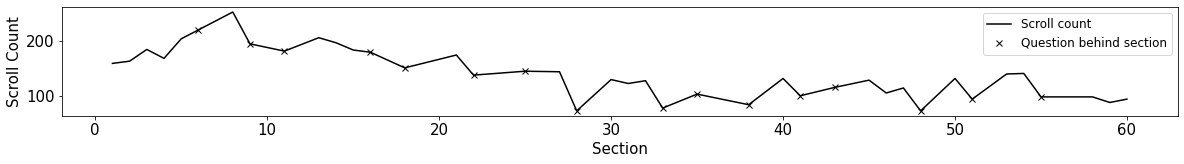

In [208]:
ax = df_scroll[~df_scroll.paragraph.isin(question_paragraphs)].groupby("paragraph").count()["id"].plot(color="black")
cnts.plot(linestyle="", marker="x", ax=ax, legend=True, xlabel="Section", ylabel="Scroll Count", figsize=(20,2), color="black")
ax.legend(["Scroll count", "Question behind section"]);
plt.savefig("scroll_count.png", dpi=300, bbox_inches = "tight")

# Results

## Only users that finished posttest

In [209]:
df_attempts = df_attempts[df_attempts["userid"].isin(usersfinished)]
df_questions = df_questions[df_questions["userid"].isin(usersfinished)]
df_scroll = df_scroll[df_scroll["userid"].isin(usersfinished)]

## Pretest results per group

In [210]:
grp = df_attempts[df_attempts.quiz == pretestid].groupby("groupid")["fraction"]
grp.mean(), grp.std()

(groupid
 1.0    0.582738
 2.0    0.567960
 Name: fraction, dtype: float64,
 groupid
 1.0    0.147914
 2.0    0.151466
 Name: fraction, dtype: float64)

In [211]:
levene(grp.get_group(1), grp.get_group(2)), ttest_ind(grp.get_group(1), grp.get_group(2))

(LeveneResult(statistic=0.01944331741620347, pvalue=0.8896123758205647),
 Ttest_indResult(statistic=0.37251796316939695, pvalue=0.7109389064307382))

In [212]:
df_attempts[df_attempts.quiz == pretestid]["fraction"].mean()

0.5752192763157894

### Question / item difficulty


In [213]:
grp = df_questions[(df_questions.contextid == pretestcontextid) & (df_questions.state.str.startswith("grade"))].groupby(["slot", "questionid"])["fraction"]
grp.mean(), grp.std()

(slot  questionid
 1     20            0.666667
 2     3             0.410606
 3     5             0.955357
 4     6             0.268421
 5     10            0.580357
 6     12            0.566964
 7     16            0.484849
 8     18            0.763636
 Name: fraction, dtype: float64,
 slot  questionid
 1     20            0.281718
 2     3             0.267329
 3     5             0.197180
 4     6             0.319127
 5     10            0.238876
 6     12            0.279980
 7     16            0.255138
 8     18            0.269680
 Name: fraction, dtype: float64)

## Posttest results per group

In [214]:
grp = df_attempts[df_attempts.quiz == posttestid].groupby("groupid")["fraction"]
grp.mean(), grp.std()

(groupid
 1.0    0.710893
 2.0    0.693333
 Name: fraction, dtype: float64,
 groupid
 1.0    0.140437
 2.0    0.122657
 Name: fraction, dtype: float64)

In [215]:
levene(grp.get_group(1), grp.get_group(2)), ttest_ind(grp.get_group(1), grp.get_group(2))

(LeveneResult(statistic=0.5589164696479523, pvalue=0.45788175818373567),
 Ttest_indResult(statistic=0.5032855928782297, pvalue=0.6167732261361779))

In [216]:
df_attempts[df_attempts.quiz == posttestid]["fraction"].mean()

0.7019590701754383

### Question / item difficulty


In [217]:
grp = df_questions[(df_questions.contextid == posttestcontextid) & (df_questions.state.str.startswith("grade"))].groupby(["slot", "questionid"])["fraction"]
grp.mean(), grp.std()

(slot  questionid
 1     20            0.625731
 2     1             0.785714
 3     2             0.803571
 4     4             0.517857
 5     5             0.964912
 6     9             0.947368
 7     10            0.657895
 8     6             0.545614
 9     17            0.674107
 10    11            0.842105
 11    14            0.573099
 12    19            0.750877
 13    15            0.649123
 14    13            0.643275
 15    12            0.683036
 16    16            0.607143
 17    8             0.719298
 18    3             0.532738
 19    7             0.736842
 20    18            0.875000
 Name: fraction, dtype: float64,
 slot  questionid
 1     20            0.244545
 2     1             0.414039
 3     2             0.400892
 4     4             0.310878
 5     5             0.185637
 6     9             0.225282
 7     10            0.273990
 8     6             0.343340
 9     17            0.277651
 10    11            0.252804
 11    14            0.241969
 

## Posttest results per group considering item difficulty

In [218]:
items = df_questions[(df_questions.contextid == posttestcontextid) & (df_questions.state.str.startswith("grade"))].groupby(["slot", "questionid"])["fraction"].mean()
grp = df_questions[(df_questions.contextid == posttestcontextid) & (df_questions.state.str.startswith("grade")) & (df_questions.questionid.isin(items[(items >= 0.6) & (items <= 0.70)].index.get_level_values("questionid")))].groupby("groupid")["fraction"]
grp.mean(), grp.std()

(groupid
 1.0    0.660714
 2.0    0.636667
 Name: fraction, dtype: float64,
 groupid
 1.0    0.262914
 2.0    0.265770
 Name: fraction, dtype: float64)

In [219]:
levene(grp.get_group(1), grp.get_group(2)), ttest_ind(grp.get_group(1), grp.get_group(2))

(LeveneResult(statistic=0.023938827945572106, pvalue=0.8771198885188121),
 Ttest_indResult(statistic=0.9050465497126916, pvalue=0.3659938093362066))

## Posttest results per group considering item-total correlation (Trennschärfe)

In [220]:
df_question_stats[df_question_stats.discriminationindex < 40.5]

,id,hashcode,timemodified,questionid,slot,subquestion,variant,s,effectiveweight,negcovar,discriminationindex,discriminativeefficiency,sd,facility,subquestions,maxmark,positions,randomguessscore
0,908,b441fd04c486a59f671bc8ce193be3acf87e8aed,1666941648,20,1,0,NaN,73,4.03012,0,38.28559,42.35385,0.256655,0.607306,NaN,1.0,1,NaN
1,909,b441fd04c486a59f671bc8ce193be3acf87e8aed,1666941648,1,2,0,NaN,73,5.53130,0,34.51480,41.37362,0.467758,0.684932,NaN,1.0,2,0.25
2,910,b441fd04c486a59f671bc8ce193be3acf87e8aed,1666941649,2,3,0,NaN,73,5.51042,0,35.76499,44.06730,0.455810,0.712329,NaN,1.0,3,0.50
4,912,b441fd04c486a59f671bc8ce193be3acf87e8aed,1666941649,5,5,0,NaN,73,3.87569,0,39.31581,64.14334,0.234894,0.938356,NaN,1.0,5,NaN
5,913,b441fd04c486a59f671bc8ce193be3acf87e8aed,1666941649,9,6,0,NaN,73,4.28871,0,40.20202,62.82346,0.276557,0.917808,NaN,1.0,6,0.50


In [221]:
itemsWithLowCorrelation = df_question_stats[df_question_stats.discriminationindex < 40.5].questionid

In [222]:
grp = df_questions[(df_questions.contextid == posttestcontextid) & (df_questions.state.str.startswith("grade")) & (~df_questions.questionid.isin(itemsWithLowCorrelation))].groupby("groupid")["fraction"]
grp.mean(), grp.std()

(groupid
 1.0    0.689976
 2.0    0.645271
 Name: fraction, dtype: float64,
 groupid
 1.0    0.282658
 2.0    0.285236
 Name: fraction, dtype: float64)

In [223]:
levene(grp.get_group(1), grp.get_group(2)), ttest_ind(grp.get_group(1), grp.get_group(2))

(LeveneResult(statistic=0.00034268304534699573, pvalue=0.9852350033990979),
 Ttest_indResult(statistic=2.2933744590490557, pvalue=0.022070597257003177))

In [224]:
tval, pval = ttest_ind(grp.get_group(1), grp.get_group(2))
tval, pval 

(2.2933744590490557, 0.022070597257003177)

In [225]:
effsize = pg.compute_effsize(grp.get_group(1), grp.get_group(2), eftype="cohen")
effsize

0.15743002969879955

### Plot

[Text(0, 0, 'Experimental'), Text(1, 0, 'Control')]

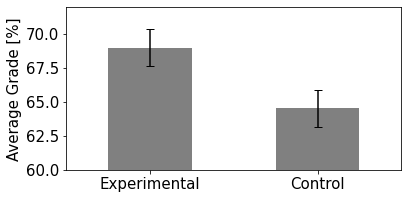

In [226]:
import numpy as np, scipy.stats as st
import matplotlib
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter

ax = (100*grp.mean()).plot(kind="bar", figsize=(6,3), yerr=100*grp.sem(), capsize=4, xlabel="", ylabel="Average Grade [%]", ylim=[60,72], color="grey")
ax.set_xticklabels(["Experimental", "Control"], rotation=0)
#ax.set_yticks([0, .1,.2,.3,.4,.5,.6,.7,.8,.9,1])
#plt.savefig("average_grades_per_group.png", dpi=300, bbox_inches = "tight")

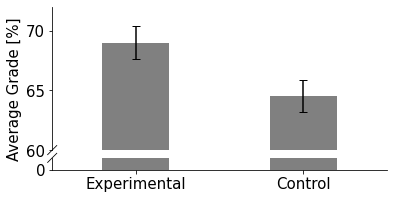

In [227]:
fig = plt.figure(figsize=(6, 3))
bax = brokenaxes(ylims=((0,1),(60,72)), hspace=0.1)
bax.bar(["Experimental", "Control"], 100*grp.mean(), width=0.4, yerr=100*grp.sem(), capsize=4, color="grey")
bax.set_ylabel("Average Grade [%]")
bax.set_xlim(-0.5, 1.5)
bax.set_xticks(["Experimental", "Control"])
plt.savefig("average_grades_per_group.png", dpi=300, bbox_inches = "tight")

## Power Analysis

In [228]:
grp.get_group(1)

1319    0.166667
1322    0.750000
1323    0.600000
1324    1.000000
1325    1.000000
          ...   
6992    0.500000
6993    1.000000
6994    0.333333
6995    1.000000
6996    1.000000
Name: fraction, Length: 419, dtype: float64

In [229]:
obj = TTestIndPower()
power = obj.power(effect_size=effsize, alpha=0.05, nobs1=n_exp, ratio=n_cont/n_exp)
power

0.089879753616888

## Difference between pretest and posttest results

In [230]:
(df_attempts[df_attempts.quiz == posttestid]["fraction"]).mean() - \
(df_attempts[df_attempts.quiz == pretestid]["fraction"]).mean()

0.12673979385964895

### Paired t-test

In [231]:
pretest = df_attempts[df_attempts.quiz == posttestid]["fraction"]
posttest = df_attempts[df_attempts.quiz == pretestid]["fraction"]
ttest_rel(pretest, posttest)

Ttest_relResult(statistic=6.467099906296823, pvalue=2.6167804739219375e-08)

### Gain-Score-Analysis

In [232]:
gainscore = df_attempts.set_index("userid")
gainscore["gainscore"] = gainscore[gainscore.quiz == posttestid]["fraction"] - gainscore[gainscore.quiz == pretestid]["fraction"] 
grp = gainscore.groupby("groupid")["gainscore"]
levene(grp.get_group(1), grp.get_group(2)), ttest_ind(grp.get_group(1), grp.get_group(2))

(LeveneResult(statistic=2.3718934885839094, pvalue=0.1263577457889704),
 Ttest_indResult(statistic=0.10602654982204422, pvalue=0.9157509562471534))

### Gain-Score-Analysis only pretest questions

In [233]:
gainscore = df_questions[(df_questions.state.str.startswith("grade"))].set_index(["userid", "questionid"])
gainscore["gainscore"] = gainscore[gainscore.contextid == posttestcontextid]["fraction"] - gainscore[gainscore.contextid == pretestcontextid]["fraction"] 
gainscore = gainscore[~gainscore.gainscore.isna()]

In [234]:
grp = gainscore.groupby("groupid")["gainscore"]
grp.mean(), grp.std(), levene(grp.get_group(1), grp.get_group(2)), ttest_ind(grp.get_group(1), grp.get_group(2))

(groupid
 1.0    0.099394
 2.0    0.096114
 Name: gainscore, dtype: float64,
 groupid
 1.0    0.357261
 2.0    0.304637
 Name: gainscore, dtype: float64,
 LeveneResult(statistic=5.675364352309571, pvalue=0.01741533837383737),
 Ttest_indResult(statistic=0.14712926361103518, pvalue=0.883063540052449))

### Gain-Score-Analysis without low correlation questions

#### Per question

In [235]:
gainscore = df_questions[(df_questions.state.str.startswith("grade")) & (~df_questions.questionid.isin(itemsWithLowCorrelation))].set_index(["userid", "questionid"])
gainscore["gainscore"] = gainscore[gainscore.contextid == posttestcontextid]["fraction"] - gainscore[gainscore.contextid == pretestcontextid]["fraction"] 
gainscore = gainscore[~gainscore.gainscore.isna()]
grp = gainscore.groupby("groupid")["gainscore"]
grp.mean(), grp.std(), levene(grp.get_group(1), grp.get_group(2)), ttest_ind(grp.get_group(1), grp.get_group(2))

(groupid
 1.0    0.151626
 2.0    0.122088
 Name: gainscore, dtype: float64,
 groupid
 1.0    0.348553
 2.0    0.317193
 Name: gainscore, dtype: float64,
 LeveneResult(statistic=3.1659254822262852, pvalue=0.07565132186384815),
 Ttest_indResult(statistic=1.1388704548011142, pvalue=0.2551716406643798))

#### Per test

In [236]:
gainscore = df_questions[(df_questions.state.str.startswith("grade")) & (~df_questions.questionid.isin(itemsWithLowCorrelation))].groupby(["userid", "contextid"]).mean().reset_index(["contextid"])
gainscore.loc[gainscore.contextid == pretestcontextid, "fraction"] *= -1
grp = gainscore.groupby(["userid", "groupid"]).sum().groupby("groupid")["fraction"]
grp.mean(), grp.std(), levene(grp.get_group(1), grp.get_group(2)), ttest_ind(grp.get_group(1), grp.get_group(2))

(groupid
 1.0    0.179402
 2.0    0.140144
 Name: fraction, dtype: float64,
 groupid
 1.0    0.192793
 2.0    0.124326
 Name: fraction, dtype: float64,
 LeveneResult(statistic=3.135253214537067, pvalue=0.0821581092919971),
 Ttest_indResult(statistic=0.9168969629038225, pvalue=0.36319976725308056))